Copyright (C) 2016 Glencoe Software, Inc.
All Rights Reserved.

This program is free software; you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation; either version 2 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License along
with this program; if not, write to the Free Software Foundation, Inc.,
51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.

# Working with the analytical data stored on the OMERO server

 * Train the classifier using positive and negtive control cells ([scikit-learn](http://scikit-learn.org/stable/modules/svm.html))
 * Use the trained classifier to count the number of negative and positive cells at each doseage level ([scikit-learn](http://scikit-learn.org/stable/modules/svm.html))

This notebook demonstarates how to retrieve analytical data stored as an [OMERO.table](http://downloads.openmicroscopy.org/omero/5.2.4/api/slice2html/omero/grid/Table.html) from the [OMERO.server](http://www.openmicroscopy.org/site/products/omero) and use it to run supervised machine learning algorithms using [scikit-learn](http://scikit-learn.org/stable/modules/svm.html).

The example below uses the output of the image processing performed using the [CellProfiler](http://cellprofiler.org/) on the [SBS Bioimage](http://cellprofiler.org/examples.html#SBS_Bioimage_CNT) dataset. Derived features (parameters describing cells' shape, instenisty and texture) are then used to build classifier using [scikit-learn]((http://scikit-learn.org/stable/modules/svm.html) that can distinguish between the positive control and the negative control cells. Finally the classifier is used to score the number of postive and negative cells at the different dose levels.

The video tutorial for this notebook can be found on [Glencoe Software, Inc.](http://glencoesoftware.com/webinars.html) website (look for: OMERO Plus for High Content Screening & Analysis: The Gold Standard in Data Management & Integration).

### Connect to OMERO server

In [14]:
import os
import omero
from omero.gateway import BlitzGateway

import gs_analytics
from getpass import getpass

from getpass import getpass
conn = BlitzGateway(
    raw_input("Username: "), getpass("OMERO Password: "),
    host=raw_input("Host: "), port=int(raw_input("Port: ")))
conn.connect()

Username: your_username
OMERO Password: ········
Host: your.server.address
Port: 4064


False

### Import matplotlib

In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (12.0, 7.0)

from IPython.display import display, HTML
import pprint

### Import scikit-learn

In [3]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import sklearn.svm as svm
from sklearn.preprocessing import StandardScaler

### Request OMERO.table object

In [4]:
shared_resources = conn.c.sf.sharedResources()
original_file_id = raw_input("OMERO.table file id: ")
original_file = omero.model.OriginalFileI(original_file_id, False)
omero_table = shared_resources.openTable(original_file)
column_names = [col.name for col in omero_table.getHeaders()]
number_of_rows = omero_table.getNumberOfRows()
print "First ten columns:\n%s\n" % pprint.pformat(column_names[0:9])
print "Table contains %s rows" % number_of_rows

OMERO.table file id: 66214
First ten columns:
['ImageNumber',
 'ObjectNumber',
 'Metadata_Column',
 'Metadata_Row',
 'Metadata_SBS_Controls',
 'Metadata_SBS_Doses',
 'Metadata_Well',
 'AreaShape_Area',
 'AreaShape_Center_X']

Table contains 17876 rows


### Select columns with numerical data

In [5]:
black_list = [
    'ImageNumber', 'ObjectNumber', 'Metadata_Column', 'Metadata_Row',
    'Metadata_SBS_Controls', 'Metadata_SBS_Doses', 'Metadata_Well'
]
column_indices = []
for column_name in column_names:
    if column_name in black_list:
        continue
    column_indices.append(column_names.index(column_name))
print "Selected %i columns." % len(column_indices)

Selected 78 columns.


### Read in data and the column containing the class labels

In [6]:
table_data = omero_table.read(column_indices, 0, number_of_rows)
data = []
for index in range(number_of_rows):
    row_values = [column.values[index] for column in table_data.columns]
    data.append(row_values)
label_column_index = column_names.index('Metadata_SBS_Doses')
label_column = omero_table.read([label_column_index], 0, number_of_rows)
label_column = label_column.columns[0].values
class_labels = np.array(label_column)

negative_dose = 0
positive_dose = 10
label_values = [negative_dose, positive_dose]

### Train the classifier

In [7]:
def train_with_feature_selection(x, y):
    '''
    Train the classifier with the feature selection.
    '''
    etc = LinearSVC(penalty="l1", dual=False)
    etc = etc.fit(x, y)
    model = SelectFromModel(etc, prefit=True)
    x_new = model.transform(x)
    print "Selected %i features using the linear SVC model." % x_new.shape[1]
    clf = svm.SVC(kernel='linear', C=1)
    clf.fit(x_new, y)
    return {'clf': clf, 'model': model}

In [8]:
clf_samples = []
clf_labels = []
for value in label_values:
    label_query = [int(x) == int(value) for x in class_labels]
    positions = [i[0] for i in enumerate(label_query) if i[1]]
    samples = [data[i] for i in positions]
    labels = [value] * len(samples)
    print "Found %i rows for label %s" % (len(labels), value)
    clf_samples.extend(samples)
    clf_labels.extend(labels)

Found 3152 rows for label 0
Found 1692 rows for label 10


In [9]:
clf = train_with_feature_selection(clf_samples, clf_labels)

Selected 42 features using the linear SVC model.


### Classify all the objects

In [10]:
def get_scores(clf, data, class_labels, positive_value, negative_value):
    '''
    Find the number of positive and negative controls for each label.
    '''
    result_pos = []
    result_neg = []
    print "Scoring positive values: %s and negative values: %s" \
        % (positive_value, negative_value)
    for i in range(11):
        labels = [int(x) == int(i) for x in class_labels]
        Y = [label[0] for label in enumerate(labels) if label[1]]
        X = [data[x] for x in Y]
        result = clf.predict(X)
        neg = [a for a in clf.predict(X) if a == negative_value]
        pos = [a for a in clf.predict(X) if a == positive_value]
        result_pos.append(100.0 * float(len(pos)) / float(len(result)))
        result_neg.append(100.0 * float(len(neg)) / float(len(result)))
        print "Label %s; Positive cells: %s, Negative cells: %s" % \
            (i, result_pos[i], result_neg[i])
    return {'negative': result_neg, 'positive': result_pos}

In [11]:
print "Classifing %i objects using %i samples" % \
    (len(data), len(clf_samples))
new_data = clf['model'].transform(data)
scores = get_scores(clf['clf'], new_data, class_labels, label_values[1], label_values[0])

Classifing 17876 objects using 4844 samples
Scoring positive values: 10 and negative values: 0
Label 0; Positive cells: 0.697969543147, Negative cells: 99.3020304569
Label 1; Positive cells: 3.84364820847, Negative cells: 96.1563517915
Label 2; Positive cells: 2.79441117764, Negative cells: 97.2055888224
Label 3; Positive cells: 11.8569636136, Negative cells: 88.1430363864
Label 4; Positive cells: 48.5155195682, Negative cells: 51.4844804318
Label 5; Positive cells: 91.7638483965, Negative cells: 8.2361516035
Label 6; Positive cells: 96.6966966967, Negative cells: 3.3033033033
Label 7; Positive cells: 97.7339181287, Negative cells: 2.26608187135
Label 8; Positive cells: 97.2346786248, Negative cells: 2.76532137519
Label 9; Positive cells: 96.3527851459, Negative cells: 3.64721485411
Label 10; Positive cells: 97.6359338061, Negative cells: 2.36406619385


### Visualise the result

In [12]:
def plot_result(X_values, Y_values):
    plt.figure()
    plt.xlabel("Dose")
    plt.ylabel("% of cell type")
    plt.plot(X_values, Y_values['positive'], c='r', marker='v', label="positive", linewidth=2)
    plt.plot(X_values, Y_values['negative'], c='b', marker='o', label="negative", linewidth=2)
    plt.legend(
        ["Positive cells", "Negive cells (dose=0)"],
        bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(True)
    plt.show()

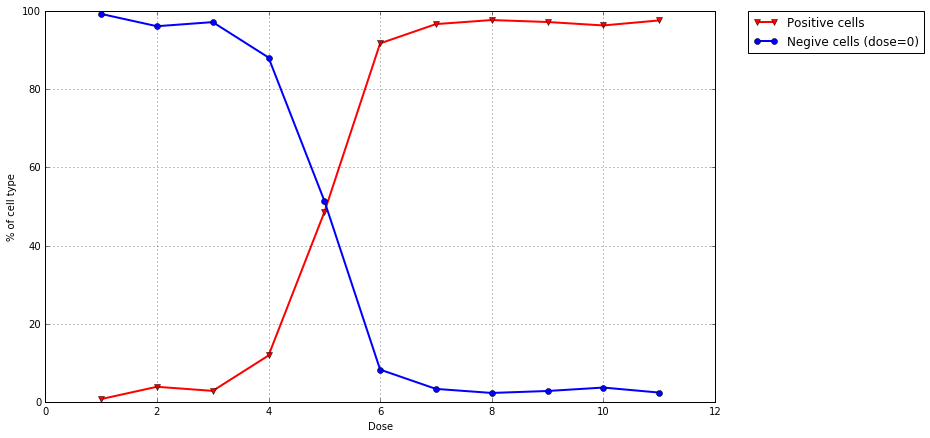

In [13]:
plot_result(range(1,12), scores)

### Disconnect from the OMERO server

In [15]:
conn._closeSession()